# Цены акций компаний и их объем

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

import re
from tqdm import tqdm

import requests
import datetime
import time
from random import uniform, randint

In [2]:
username = '...'
password = '...'
host = '...'
port = '...'
database = '...'
conn_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'

## Загрузка данных с базы данных

In [3]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

companies_df = pd.read_sql_query('SELECT * FROM companies_tickets', conn)
conn.close()

## Загрузка данных с Мосбиржи и обогащение существующего датасета

In [4]:
companies_string = 'http://iss.moex.com/iss/engines/stock/markets/shares/securities/{}/candles.json?from={}&till={}&interval=1'

In [5]:
companies_df['price_release'] = np.nan
companies_df['volume_release'] = np.nan
companies_df['price_lag_30'] = np.nan
companies_df['volume_lag_30'] = np.nan

In [6]:
companies_df = companies_df.sort_values(by=['datetime'])

In [7]:
for i in tqdm(range(len(companies_df))):
    start = companies_df['datetime'][i]
    end = companies_df['datetime'][i] + datetime.timedelta(minutes=30)
    company = companies_df['company'][i]
    connect_timeout = 300
    read_timeout = 120
    n = requests.get(companies_string.format(company, start, end), timeout=(connect_timeout, read_timeout)).json()
    try:
        companies_df.loc[i, 'price_release'] = n['candles']['data'][0][0]
        companies_df.loc[i, 'volume_release'] = n['candles']['data'][0][4]
        companies_df.loc[i, 'price_lag_30'] = n['candles']['data'][-1][0]
        companies_df.loc[i, 'volume_lag_30'] = n['candles']['data'][-1][4]
    except IndexError:
        continue
#     if i % randint() == 0:
#         delay = uniform(5, 10)
#         time.sleep(delay)

100%|██████████████████████████████████████████████████████████████████████████████| 7542/7542 [11:38<00:00, 10.80it/s]


In [8]:
companies_df.isna().sum()

website             0
section             0
url                 0
header              0
body                0
tags              733
body_length         0
datetime            0
company             0
price_release     275
volume_release    275
price_lag_30      275
volume_lag_30     275
dtype: int64

> **Комментарий:** У нас 275 пропусков, связано это с тем, что в этот день с конкретным инструментом были определенные проблемы: были приостановлены торги или закорраптились данные. Сделать с этим мы ничего не можем, поэтому просто убираем эти наблюдения

In [9]:
companies_df = companies_df.dropna(subset=['price_release'])

## Получение разниц

In [10]:
companies_df['price_diff'] = companies_df['price_lag_30'] - companies_df['price_release']
companies_df['price_diff_percent'] = companies_df['price_diff'] / companies_df['price_release'] * 100
companies_df['volume_diff'] = companies_df['volume_lag_30'] - companies_df['volume_release']
companies_df['volume_diff_percent'] = companies_df['volume_diff'] / companies_df['volume_release'] * 100

## Немного наблюдений

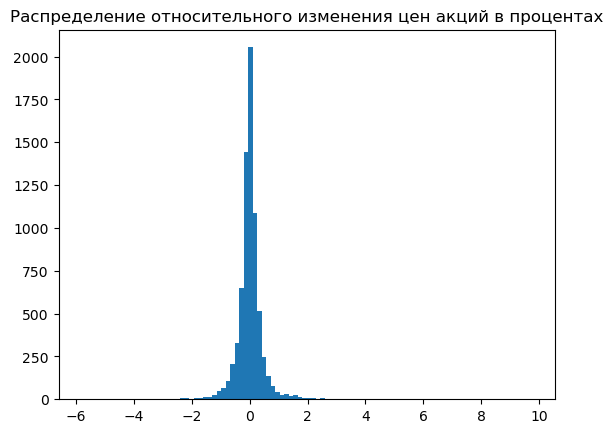

In [47]:
plt.hist(companies_df.price_diff_percent, bins=100)
plt.title('Распределение относительного изменения цен акций в процентах')
plt.show()

> **Комментарий:** Легко заметить, что распределение получилось вполне логичным: симметричным и с сильным эксцессом в нуле

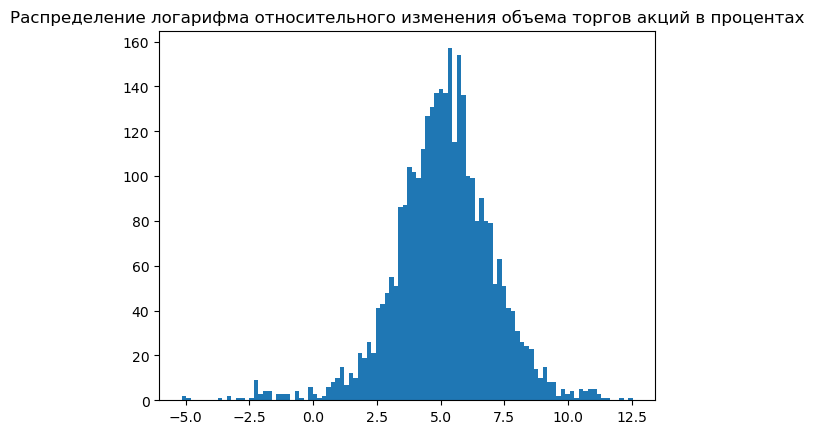

In [29]:
plt.hist(np.log(companies_df.volume_diff_percent+0.1), bins=100)
plt.title('Распределение логарифма относительного изменения объема торгов акций в процентах')
plt.show()

> **Комментарий:** Получили, что относительное изменение объема торгов акций имеет, примерно, лог-нормальное распределение

## Выгрузка и проверка

In [31]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True
companies_df.to_sql('companies_trade', con=conn, if_exists='replace', index=False) 
conn.close()

In [32]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe = pd.read_sql_query('SELECT * FROM companies_trade', conn)
conn.close()

print(dataframe.shape)
dataframe.head()

(7267, 17)


,website,section,url,header,body,tags,body_length,datetime,company,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,SBER,142.75,11917688.40,142.62,2958789.90,-0.13,-0.091068,-8958898.5,-75.173122
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,GAZP,163.13,1100961.10,163.37,1413064.30,0.24,0.147122,312103.2,28.348250
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,ROSN,363.70,178263.05,364.85,321423.75,1.15,0.316195,143160.7,80.308679
3,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,SBER,141.31,1573757.40,141.40,2401025.00,0.09,0.063690,827267.6,52.566399
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,GAZP,161.69,4620114.20,161.60,1373716.00,-0.09,-0.055662,-3246398.2,-70.266622


# Индустриальные индексы

## Загрузка данных с базы данных

In [33]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

ind_df = pd.read_sql_query('SELECT * FROM industries_tickets', conn)
conn.close()

## Загрузка данных с Мосбиржи и обогащение существующего датасета

In [35]:
ind_string = 'http://iss.moex.com/iss/engines/stock/markets/index/boards/SNDX/securities/{}/candles.json?from={}&till={}&interval=1'

In [36]:
ind_df['price_release'] = np.nan
ind_df['volume_release'] = np.nan
ind_df['price_lag_30'] = np.nan
ind_df['volume_lag_30'] = np.nan

In [37]:
ind_df = ind_df.sort_values(by=['datetime'])

In [38]:
for i in tqdm(range(len(ind_df))):
    start = ind_df['datetime'][i]
    end = ind_df['datetime'][i] + datetime.timedelta(minutes=30)
    ind = ind_df['industry'][i]
    connect_timeout = 100000
    read_timeout = 100000
    n = requests.get(ind_string.format(ind, start, end), timeout=(connect_timeout, read_timeout)).json()
    try:
        ind_df.loc[i, 'price_release'] = n['candles']['data'][0][0]
        ind_df.loc[i, 'volume_release'] = n['candles']['data'][0][4]
        ind_df.loc[i, 'price_lag_30'] = n['candles']['data'][-1][0]
        ind_df.loc[i, 'volume_lag_30'] = n['candles']['data'][-1][4]
    except IndexError:
        continue
#     delay = uniform(0, 3)
#     time.sleep(delay)

100%|██████████████████████████████████████████████████████████████████████████████| 6228/6228 [08:00<00:00, 12.96it/s]


In [39]:
ind_df.isna().sum()

website              0
section              0
url                  0
header               0
body                 0
tags               564
body_length          0
datetime             0
industry             0
price_release     1473
volume_release    1473
price_lag_30      1473
volume_lag_30     1473
dtype: int64

> **Комментарий:** У нас получилось 1473 пропуска, связано это с тем, что в отличии от остальных инструментов, которые мы рассматриваем, отраслевые индексы имеют более узкое окно времени для торгов, как следствие, значительная часть наблюдений в нашей выборке не подходит, так как эти наблюдения в это окно не попадают. Сделать с этим мы ничего не можем, поэтому просто убираем эти наблюдения

In [40]:
ind_df = ind_df.dropna(subset=['price_release'])

## Получение разниц

In [42]:
ind_df['price_diff'] = ind_df['price_lag_30'] - ind_df['price_release']
ind_df['price_diff_percent'] = ind_df['price_diff'] / ind_df['price_release'] * 100
ind_df['volume_diff'] = ind_df['volume_lag_30'] - ind_df['volume_release']
ind_df['volume_diff_percent'] = ind_df['volume_diff'] / ind_df['volume_release'] * 100

## Немного наблюдений

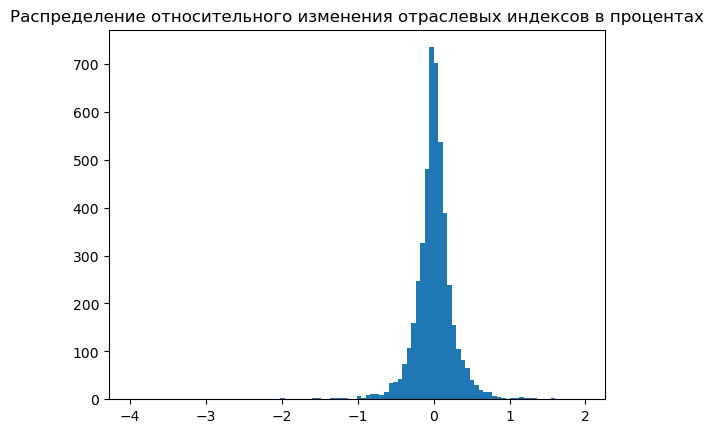

In [46]:
plt.hist(ind_df.price_diff_percent, bins=100)
plt.title('Распределение относительного изменения отраслевых индексов в процентах')
plt.show()

> **Комментарий:** Легко заметить, что распределение получилось вполне логичным: симметричным и с сильным эксцессом в нуле

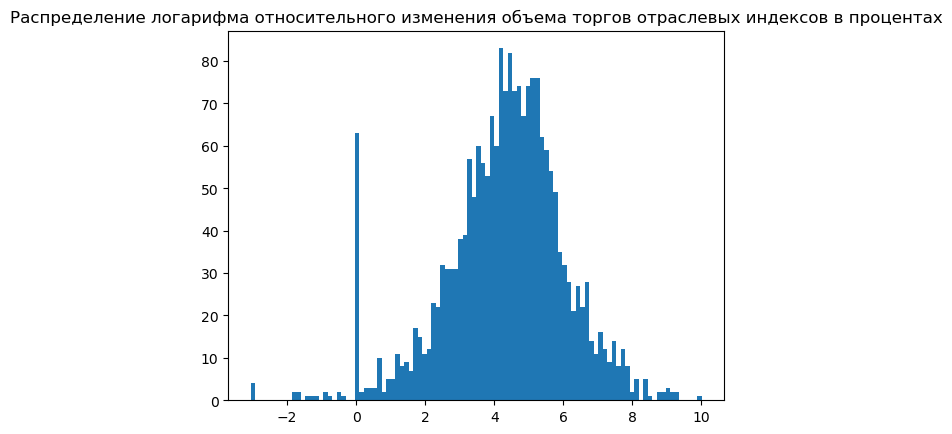

In [58]:
plt.hist(np.log(ind_df.volume_diff_percent+1), bins=100)
plt.title('Распределение логарифма относительного изменения объема торгов отраслевых индексов в процентах')
plt.show()

> **Комментарий:** Получили, что относительное изменение объема торгов акций имеет, примерно, лог-нормальное распределение с фигофиной слева, вызванной нулями

## Выгрузка и проверка

In [97]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True
ind_df.to_sql('industries_trade', con=conn, if_exists='replace', index=False) 
conn.close()

In [98]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe = pd.read_sql_query('SELECT * FROM industries_trade', conn)
conn.close()

print(dataframe.shape)
dataframe.head()

(4755, 17)


,website,section,url,header,body,tags,body_length,datetime,industry,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,MOEXFN,6307.20,16806757.15,6308.77,11854100.00,1.57,0.024892,-4952657.15,-29.468250
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,MOEXOG,5696.30,4451180.75,5696.72,4605859.35,0.42,0.007373,154678.60,3.475002
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,MOEXOG,5655.65,3325798.35,5663.65,1490555.35,8.00,0.141451,-1835243.00,-55.182029
3,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,MOEXFN,6298.36,7394623.45,6296.27,3371524.05,-2.09,-0.033183,-4023099.40,-54.405737
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,MOEXOG,5655.00,15940301.65,5647.93,1358915.70,-7.07,-0.125022,-14581385.95,-91.474969


# Индекс Мосбиржи, RVI и фьючерс на курс доллара

## Загрузка данных с базы данных

In [62]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

global_df = pd.read_sql_query('SELECT * FROM global_tickets', conn)
conn.close()

## Загрузка данных с Мосбиржи и обогащение существующего датасета

In [64]:
global_moex = 'http://iss.moex.com/iss/engines/stock/markets/index/boards/SNDX/securities/IMOEX2/candles.json?from={}&till={}&interval=1'
global_rvi = 'http://iss.moex.com/iss/engines/stock/markets/index/boards/RTSI/securities/RVI/candles.json?from={}&till={}&interval=1'
global_usd_rub_fut = 'http://iss.moex.com/iss/engines/futures/markets/forts/boards/RFUD/securities/{}/candles.json?from={}&till={}&interval=1'

In [65]:
global_df['imoex_price_release'] = np.nan
# global_df['imoex_volume_release'] = np.nan
global_df['imoex_price_lag_30'] = np.nan
# global_df['imoex_volume_lag_30'] = np.nan

global_df['rvi_price_release'] = np.nan
global_df['rvi_price_lag_30'] = np.nan

global_df['usd_price_release'] = np.nan
global_df['usd_price_lag_30'] = np.nan

In [66]:
global_df = global_df.sort_values(by=['datetime'])

In [67]:
for i in tqdm(range(len(global_df))):
    start = global_df['datetime'][i]
    end = global_df['datetime'][i] + datetime.timedelta(minutes=30)
    connect_timeout = 300
    read_timeout = 120
    n = requests.get(global_moex.format(start, end), timeout=(connect_timeout, read_timeout)).json()
    try:
        global_df.loc[i, 'imoex_price_release'] = n['candles']['data'][0][0]
#         global_df.loc[i, 'imoex_volume_release'] = n['candles']['data'][0][4]
        global_df.loc[i, 'imoex_price_lag_30'] = n['candles']['data'][-1][0]
#         global_df.loc[i, 'imoex_volume_lag_30'] = n['candles']['data'][-1][4]
    except IndexError:
        continue
    n = requests.get(global_rvi.format(start, end), timeout=(connect_timeout, read_timeout)).json()
    try:
        global_df.loc[i, 'rvi_price_release'] = n['candles']['data'][0][0]
        global_df.loc[i, 'rvi_price_lag_30'] = n['candles']['data'][-1][0]
    except IndexError:
        continue
    if str(start) < '2023-03-16':
        n = requests.get(global_usd_rub_fut.format('SiH3', start, end), timeout=(connect_timeout, read_timeout)).json()
        try:
            global_df.loc[i, 'usd_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'usd_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            continue
    elif str(start) < '2023-06-15':
        n = requests.get(global_usd_rub_fut.format('SiM3', start, end), timeout=(connect_timeout, read_timeout)).json()
        try:
            global_df.loc[i, 'usd_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'usd_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            continue
    elif str(start) < '2023-09-21':
        n = requests.get(global_usd_rub_fut.format('SiU3', start, end), timeout=(connect_timeout, read_timeout)).json()
        try:
            global_df.loc[i, 'usd_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'usd_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            continue
    else:
        n = requests.get(global_usd_rub_fut.format('SiZ3', start, end), timeout=(connect_timeout, read_timeout)).json()
        try:
            global_df.loc[i, 'usd_price_release'] = n['candles']['data'][0][0]
            global_df.loc[i, 'usd_price_lag_30'] = n['candles']['data'][-1][0]
        except IndexError:
            continue
#     delay = randint(1,2)
#     time.sleep(delay)

100%|████████████████████████████████████████████████████████████████████████████| 13326/13326 [59:34<00:00,  3.73it/s]


In [68]:
global_df.isna().sum()

website                   0
section                   0
url                       0
header                    0
body                      0
tags                   1034
body_length               0
datetime                  0
imoex_price_release       0
imoex_price_lag_30        0
rvi_price_release        20
rvi_price_lag_30         20
usd_price_release        22
usd_price_lag_30         22
dtype: int64

> **Комментарий:** Почти нет пропусков, приятно :)

In [70]:
global_df = global_df.dropna(subset=['usd_price_release'])

## Получение разниц

In [74]:
global_df['imoex_price_diff'] = global_df['imoex_price_lag_30'] - global_df['imoex_price_release']
global_df['imoex_price_diff_percent'] = global_df['imoex_price_diff'] / global_df['imoex_price_release'] * 100
# global_df['imoex_volume_diff'] = global_df['imoex_volume_lag_30'] - global_df['imoex_volume_release']
# global_df['imoex_volume_diff_percent'] = global_df['imoex_volume_diff'] / global_df['imoex_volume_release'] * 100

global_df['rvi_price_diff'] = global_df['rvi_price_lag_30'] - global_df['rvi_price_release']
global_df['rvi_price_diff_percent'] = global_df['rvi_price_diff'] / global_df['rvi_price_release'] * 100

global_df['usd_price_diff'] = global_df['usd_price_lag_30'] - global_df['usd_price_release']
global_df['usd_price_diff_percent'] = global_df['usd_price_diff'] / global_df['usd_price_release'] * 100

## Немного наблюдений

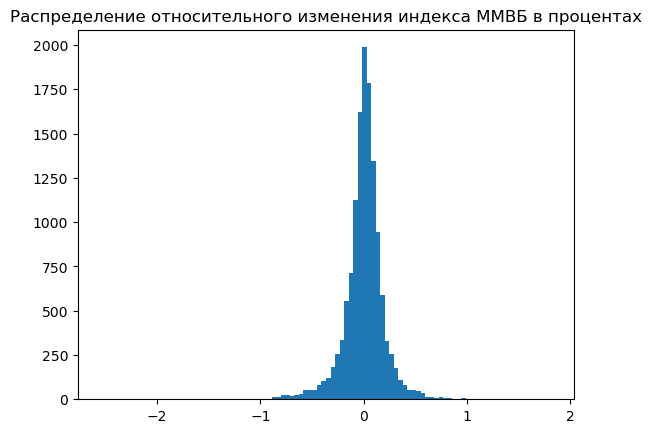

In [75]:
plt.hist(global_df.imoex_price_diff_percent, bins=100)
plt.title('Распределение относительного изменения индекса ММВБ в процентах')
plt.show()

> **Комментарий:** Легко заметить, что распределение получилось вполне логичным: симметричным и с сильным эксцессом в нуле

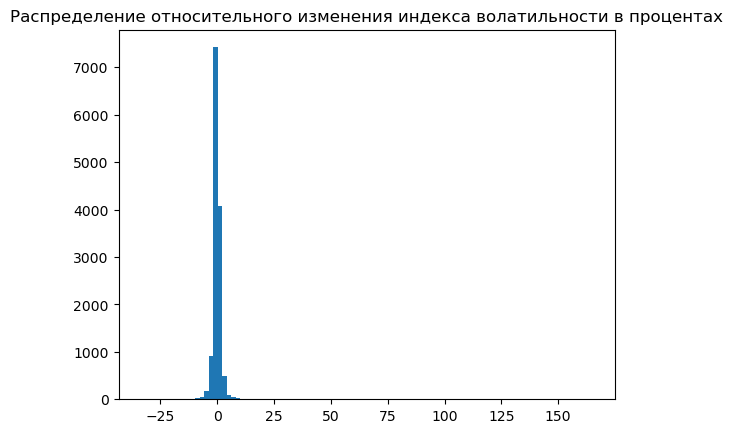

In [76]:
plt.hist(global_df.rvi_price_diff_percent, bins=100)
plt.title('Распределение относительного изменения индекса волатильности в процентах')
plt.show()

> **Комментарий:** Распределение получилось почти симметричным (правда, с некоторым очень малым количеством выбросов) и с очень сильным эксцессом в нуле

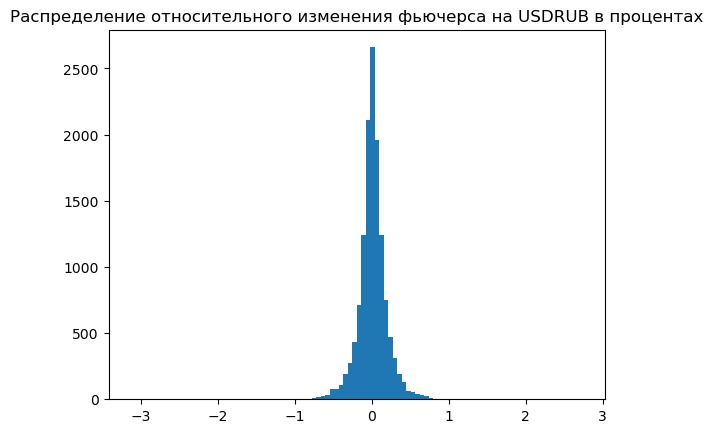

In [83]:
plt.hist(global_df.usd_price_diff_percent, bins=100)
plt.title('Распределение относительного изменения фьючерса на USDRUB в процентах')
plt.show()

> **Комментарий:** Легко заметить, что распределение получилось вполне логичным: симметричным и с сильным эксцессом в нуле

> **P.S.** Взяли фьючерс, так как у него шире окно торгов, чем у спотового USDRUB

## Выгрузка и проверка

In [99]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True
global_df.to_sql('global_trade', con=conn, if_exists='replace', index=False) 
conn.close()

In [102]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe = pd.read_sql_query('SELECT * FROM global_trade', conn)
conn.close()

print(dataframe.shape)
dataframe.head()

(13304, 20)


,website,section,url,header,body,tags,body_length,datetime,imoex_price_release,imoex_price_lag_30,rvi_price_release,rvi_price_lag_30,usd_price_release,usd_price_lag_30,imoex_price_diff,imoex_price_diff_percent,rvi_price_diff,rvi_price_diff_percent,usd_price_diff,usd_price_diff_percent
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,2166.77,2168.03,40.45,40.26,70352.0,69975.0,1.26,0.058151,-0.19,-0.469716,-377.0,-0.535877
1,РИА,Экономика,https://ria.ru/20230103/avtomobili-1842908567....,Минпромторг спрогнозировал рост производства а...,Минпромторг прогнозирует в наступившем году ...,"['Экономика', 'Авто', 'Денис Мантуров', 'Росси...",808,2023-01-03 10:20:00,2166.37,2167.18,40.45,40.25,70264.0,70008.0,0.81,0.037390,-0.20,-0.494438,-256.0,-0.364340
2,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879539,Рынок акций РФ открылся ростом индекса МосБирж...,- Рынок акций РФ открылся во вторник ростом ...,['Московская биржа'],1249,2023-01-03 10:22:00,2166.08,2166.96,40.45,40.24,70176.0,70017.0,0.88,0.040626,-0.21,-0.519159,-159.0,-0.226573
3,РИА,Экономика,https://ria.ru/20230103/nissan-1842909188.html,"""АвтоВАЗу"" передадут активы Nissan в России","Подведомственное Минпромторгу ФГУП ""НАМИ"" пе...","['Экономика', 'Авто', 'Денис Мантуров', 'Минис...",1414,2023-01-03 10:29:00,2168.32,2168.95,39.86,40.22,70051.0,70144.0,0.63,0.029055,0.36,0.903161,93.0,0.132760
4,Kommersant,Финансы,https://www.kommersant.ru/doc/5757823,"Индекс Мосбиржи растет на 0,5% на первой торго...",Индекс Московской биржи на открытии торгов рас...,None,598,2023-01-03 10:31:00,2168.03,2170.54,39.89,40.13,69940.0,70053.0,2.51,0.115773,0.24,0.601655,113.0,0.161567
